In [ ]:
import pandas as pd
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import OrdinalEncoder, StandardScaler

Unknown instance spec: Please select VM configuration

In [2]:
train_df = pd.read_csv('parsed_final_data_season_3.csv.zip', compression='zip')
test_df = pd.read_csv('final_test_data_season_3.csv.zip', compression='zip')

/tmp/ipykernel_11025/3222708738.py:1: DtypeWarning: Columns (15,16,17) have mixed types. Specify dtype option on import or set low_memory=False.
  train_df = pd.read_csv('parsed_final_data_season_3.csv.zip', compression='zip')


In [3]:
train_df = train_df.drop('Unnamed: 0', axis=1)
test_df = test_df.drop('Unnamed: 0', axis=1)

In [4]:
# train_df = train_df.fillna(value=False)

In [5]:
train_df.head()

,bid_id,region_id,city_id,ad_slot_visibility,ad_slot_format,creative_id,advertiser_id,part_of_day,weekday,weekend,os,browser,ad_slot_screen_share,is_mobile_device,is_male,is_long_term_interest,is_in_market,is_info_cat,is_products_cat,is_service_cat,is_entertainment_cat,is_girly_cat,click
0,9aa9b28f32adfc833634f28bb9703e83,216,219,Na,Fixed,7321,2259,2,3,2,windows,chrome,0.06,False,NaN,NaN,NaN,False,False,False,False,False,False
1,1ede4e457f5031ec1640dbe1259a4616,216,217,FirstView,Fixed,7321,2259,2,3,2,windows,ie,0.06,False,NaN,NaN,NaN,False,False,False,False,False,False
2,fca79371fc0f67ac6264f558bc664fd6,216,217,Na,Fixed,7323,2259,2,3,2,windows,chrome,0.07,False,NaN,NaN,NaN,False,False,False,False,False,False
3,7717c608f688ea3b087e292c91604ea5,183,184,Na,Fixed,10722,2821,2,3,2,windows,ie,0.07,False,NaN,NaN,NaN,False,False,False,False,False,False
4,35528d946791bc45b75ded2a2dbdabfe,3,3,FirstView,Fixed,10722,2821,2,3,2,windows,ie,0.07,False,NaN,NaN,NaN,False,False,False,False,False,False


In [6]:
train_df.columns

Index(['bid_id', 'region_id', 'city_id', 'ad_slot_visibility',
       'ad_slot_format', 'creative_id', 'advertiser_id', 'part_of_day',
       'weekday', 'weekend', 'os', 'browser', 'ad_slot_screen_share',
       'is_mobile_device', 'is_male', 'is_long_term_interest', 'is_in_market',
       'is_info_cat', 'is_products_cat', 'is_service_cat',
       'is_entertainment_cat', 'is_girly_cat', 'click'],
      dtype='object')

In [7]:
target_column = 'click'
categorical_features = [
    'city_id', 'ad_slot_visibility', 'ad_slot_format',
    'creative_id', 'advertiser_id', 'part_of_day', 'weekday',
    'os', 'browser', 'is_in_market', 'is_male', 'is_mobile_device',
    'is_long_term_interest',
   'is_info_cat', 'is_products_cat', 'is_service_cat',
   'is_entertainment_cat', 'is_girly_cat'
]
feature_columns = categorical_features + ["ad_slot_screen_share"]

In [8]:
def prepare_data_ord(df, feature_columns, categorical_features, ord_encoder=None, scaler=None, fit=True):
    X_cat = df[categorical_features].astype(str)
    X_num = df[[f for f in feature_columns if f not in categorical_features]]
    if fit:
        ord_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
        scaler = StandardScaler()
        X_cat_enc = ord_encoder.fit_transform(X_cat)
        X_num_enc = scaler.fit_transform(X_num)
    else:
        X_cat_enc = ord_encoder.transform(X_cat)
        X_num_enc = scaler.transform(X_num)
    X = np.hstack([X_cat_enc, X_num_enc])
    return X, ord_encoder, scaler

In [9]:
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42, stratify=train_df[target_column])

In [10]:
X_train, ord_encoder, scaler = prepare_data_ord(train_df, feature_columns, categorical_features, fit=True)
X_val, _, _ = prepare_data_ord(val_df, feature_columns, categorical_features, ord_encoder=ord_encoder, scaler=scaler, fit=False)
X_test, _, _ = prepare_data_ord(test_df, feature_columns, categorical_features, ord_encoder=ord_encoder, scaler=scaler, fit=False)
y_train = train_df[target_column].values
y_val = val_df[target_column].values
y_test = test_df[target_column].values

IOStream.flush timed out


In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {device}')

Device: cuda


In [12]:
X_train_t = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_t = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1).to(device)
X_val_t = torch.tensor(X_val, dtype=torch.float32).to(device)
y_val_t = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1).to(device)
X_test_t = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_t = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1).to(device)

In [13]:
n_pos = (y_train_t == 1).sum()
n_neg = (y_train_t == 0).sum()
pos_weight = torch.tensor([n_neg / n_pos], dtype=torch.float32).to(device)

#  WIDE&DEEP-INSPIRED NET

In [27]:
class WideAndDeepNet(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.deep = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.ReLU(),
        )
        self.wide = nn.Identity()
        self.output = nn.Linear(64 + input_dim, 1)
    def forward(self, x):
        deep_out = self.deep(x)
        wide_out = self.wide(x)
        x_cat = torch.cat([deep_out, wide_out], axis=1)
        return self.output(x_cat)

widenet = WideAndDeepNet(X_train.shape[1]).to(device)
optimizer3 = optim.Adam(widenet.parameters(), lr=0.01)
criterion3 = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

In [28]:
for epoch in range(100):
    widenet.train()
    optimizer3.zero_grad()
    output = widenet(X_train_t)
    loss = criterion3(output, y_train_t)
    loss.backward()
    optimizer3.step()
    with torch.no_grad():
        preds = torch.sigmoid(widenet(X_val_t)).cpu().numpy()
        roc_auc = roc_auc_score(y_val, preds)
    print(f"Epoch {epoch+1:2d}, ROC AUC: {roc_auc:.4f}")

Epoch  1, ROC AUC: 0.5043
Epoch  2, ROC AUC: 0.7426
Epoch  3, ROC AUC: 0.5234
Epoch  4, ROC AUC: 0.5341
Epoch  5, ROC AUC: 0.6493
Epoch  6, ROC AUC: 0.5920
Epoch  7, ROC AUC: 0.6760
Epoch  8, ROC AUC: 0.5867
Epoch  9, ROC AUC: 0.5798
Epoch 10, ROC AUC: 0.6317
Epoch 11, ROC AUC: 0.6951
Epoch 12, ROC AUC: 0.6466
Epoch 13, ROC AUC: 0.6840
Epoch 14, ROC AUC: 0.8292
Epoch 15, ROC AUC: 0.6999
Epoch 16, ROC AUC: 0.6964
Epoch 17, ROC AUC: 0.7966
Epoch 18, ROC AUC: 0.7766
Epoch 19, ROC AUC: 0.7234
Epoch 20, ROC AUC: 0.7374
Epoch 21, ROC AUC: 0.8138
Epoch 22, ROC AUC: 0.8277
Epoch 23, ROC AUC: 0.7874
Epoch 24, ROC AUC: 0.8013
Epoch 25, ROC AUC: 0.8435
Epoch 26, ROC AUC: 0.8202
Epoch 27, ROC AUC: 0.8191
Epoch 28, ROC AUC: 0.8384
Epoch 29, ROC AUC: 0.8463
Epoch 30, ROC AUC: 0.8390
Epoch 31, ROC AUC: 0.8333
Epoch 32, ROC AUC: 0.8403
Epoch 33, ROC AUC: 0.8469
Epoch 34, ROC AUC: 0.8447
Epoch 35, ROC AUC: 0.8448
Epoch 36, ROC AUC: 0.8510
Epoch 37, ROC AUC: 0.8516
Epoch 38, ROC AUC: 0.8493
Epoch 39, RO

In [29]:
widenet.eval()
with torch.no_grad():
    y_pred_wide = torch.sigmoid(widenet(X_test_t)).cpu().numpy()
roc_auc = roc_auc_score(y_test, y_pred_wide)
print('ROC AUC:', roc_auc)

ROC AUC: 0.7083902724270398


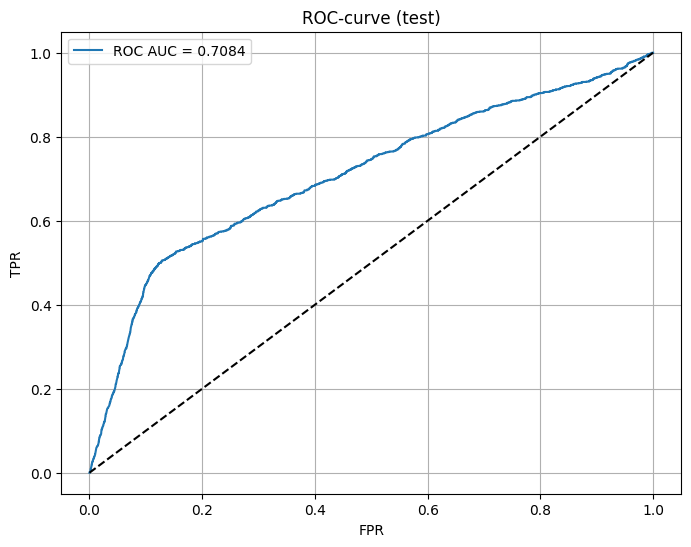

In [30]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_wide)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f"ROC AUC = {roc_auc:.4f}")
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC-curve (test)')
plt.legend()
plt.grid()
plt.show()

In [31]:
def permutation_importance(model, X, y, feature_names, device='cpu', n_repeats=2):
    baseline = roc_auc_score(y, torch.sigmoid(model(torch.tensor(X, dtype=torch.float32).to(device))).cpu().detach().numpy().squeeze())
    importances = []
    for i, fname in enumerate(feature_names):
        scores = []
        for _ in range(n_repeats):
            X_perm = X.copy()
            idx = np.random.permutation(X.shape[0])
            X_perm[:, i] = X_perm[idx, i]
            X_perm_t = torch.tensor(X_perm, dtype=torch.float32).to(device)
            pred = torch.sigmoid(model(X_perm_t)).cpu().detach().numpy().squeeze()
            score = roc_auc_score(y, pred)
            scores.append(baseline - score)
        importances.append(np.mean(scores))
    return pd.Series(importances, index=feature_names).sort_values(ascending=False)

In [32]:
feature_list = list(categorical_features) + [f for f in feature_columns if f not in categorical_features]

importances = permutation_importance(widenet, X_test, y_test, feature_list, device=device)
print("Значимость признаков (по permutation importance на тесте):")
print(importances)

Значимость признаков (по permutation importance на тесте):
browser                  0.065882
advertiser_id            0.018038
creative_id              0.008545
ad_slot_visibility       0.007753
is_mobile_device         0.002050
is_entertainment_cat     0.002029
is_male                  0.001843
part_of_day              0.001653
is_info_cat              0.001633
is_long_term_interest    0.001042
is_in_market             0.000363
os                       0.000151
is_service_cat           0.000021
ad_slot_format           0.000000
is_girly_cat            -0.000074
is_products_cat         -0.000236
ad_slot_screen_share    -0.000546
city_id                 -0.001764
weekday                 -0.006026
dtype: float64


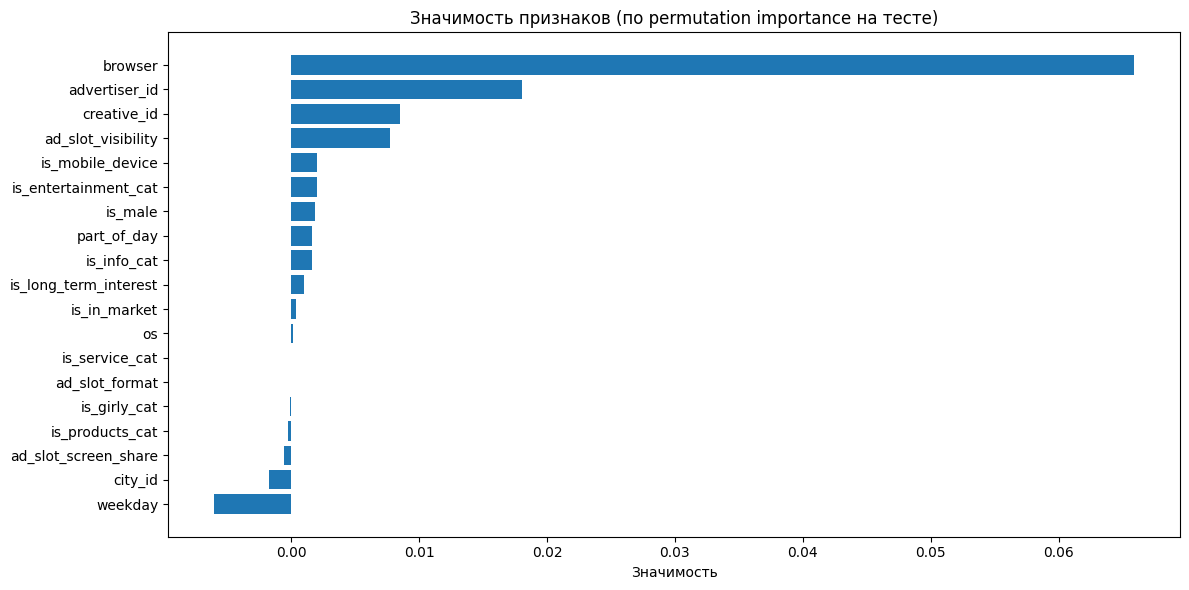

In [33]:
importances = importances.sort_values(ascending=False)
plt.figure(figsize=(12, 6))
plt.barh(importances.index[::-1], importances.values[::-1])
plt.xlabel("Значимость")
plt.title("Значимость признаков (по permutation importance на тесте)")
plt.tight_layout()
plt.show()